# Obtained_data:

In [1]:
import numpy as np 

In [2]:
import pandas as pd
user_data=pd.read_csv("Final_User_Dataset.csv")
item_data=pd.read_csv("Final_Anime_Dataset.csv")
user_input=pd.read_csv("User_input.csv")



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23064\192256860.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  item_data=pd.read_csv("Final_Anime_Dataset.csv")


In [3]:
user_data[user_data.columns[21]].dtype

dtype('float64')

In [4]:
user_data.iloc[21, :].unique()

array([347, 'troublesome4u', 'Male', 1978.0, 8.64, 167.0, 8.84, 8.83,
       7.91, 9.56, 7.06, 8.1, 8.67, 8.0, 6.79, 8.47, 7.17, 7.53, 6.47,
       8.54, 6.83, 8.57, 8.32, 7.87, 9.09, 8.69, 10.0, 47.0,
       'Retro_Anime_Lovers', 0, 1], dtype=object)

In [5]:
user_data["avg_Romance"] = pd.to_numeric(user_data["avg_Romance"], errors="coerce")


In [6]:
user_data["avg_Romance"].dtype

dtype('float64')

In [7]:
min_value = user_data['avg_Mystery'].min()
max_value = user_data['avg_Mystery'].max()
print(f"Range of avg_Mystery: {min_value} to {max_value}")

Range of avg_Mystery: 1.0 to 10.0


In [8]:
user_data["avg_Mystery"].dtype

dtype('float64')

In [9]:
item_data.shape

(24236, 1579)

In [10]:
user_data.columns

Index(['user_id', 'Username', 'Gender', 'Birth_Year', 'Mean Score',
       'Completed', 'avg_Action', 'avg_Adventure', 'avg_Avant Garde',
       'avg_Award Winning', 'avg_Boys Love', 'avg_Comedy', 'avg_Drama',
       'avg_Ecchi', 'avg_Erotica', 'avg_Fantasy', 'avg_Girls Love',
       'avg_Gourmet', 'avg_Hentai', 'avg_Horror', 'avg_Mystery', 'avg_Romance',
       'avg_Sci-Fi', 'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural',
       'avg_Suspense', 'Age', 'Viewer_Category', 'Category_Classic_Era_Fans',
       'Category_Gen_Alpha_Viewers', 'Category_Millennial_Favorites',
       'Category_Retro_Anime_Lovers', 'Category_Zoomer_Picks'],
      dtype='object')

In [11]:
item_data.columns
item_data.sample()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,"Studio_pH Studio, D & D Pictures","Studio_pH Studio, Noovo",Studio_production doA,Studio_studio MOTHER,Studio_studio YOG,Studio_trenova,Studio_ufotable,"Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive","Studio_ufotable, feel., Studio Flag",Release_Year
24094,55523,veil,veil,veil,NaN,UNKNOWN,No description available for this anime.,Music,1,"Jul 19, 2019",...,0,0,0,0,0,0,0,0,0,2019.0


In [12]:
item_data.drop(columns="Type", inplace=True)

In [13]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop=None, dtype=int)

# Fit and transform the 'Gender' column
gender_encoded = encoder.fit_transform(user_data[['Gender']])

# Get the column names for the encoded features
gender_columns = encoder.get_feature_names_out(['Gender'])

# Create a DataFrame for the encoded features
gender_encoded_df = pd.DataFrame(gender_encoded, columns=gender_columns)

# Concatenate the one-hot encoded columns with the original DataFrame
user_data = pd.concat([user_data, gender_encoded_df], axis=1)

# Drop the original 'Gender' column if no longer needed
user_data.drop(columns=['Gender'], inplace=True)

# Display the updated DataFrame
print(user_data.head())

   user_id  Username  Birth_Year  Mean Score  Completed  avg_Action  \
0        1     Xinil      1985.0        7.37      233.0        7.68   
1       20    vondur      1988.0        8.06       94.0        8.02   
2       66    Hiromi      1990.0        7.53      148.0        7.49   
3       82    Achtor      1989.0        7.17      153.0        7.36   
4      112  luffykun      1983.0        8.77      125.0        8.60   

   avg_Adventure  avg_Avant Garde  avg_Award Winning  avg_Boys Love  ...  \
0           7.90             8.00               8.18           7.06  ...   
1           8.24             9.00               8.43           7.06  ...   
2           7.31             7.00               7.90           7.06  ...   
3           7.71             8.80               8.25           7.06  ...   
4           8.36             7.91               9.80           7.06  ...   

    Age     Viewer_Category  Category_Classic_Era_Fans  \
0  40.0  Retro_Anime_Lovers                          0   


In [14]:
item_data["Rating"].values

array(['R - 17+ (violence & profanity)', 'R - 17+ (violence & profanity)',
       'PG-13 - Teens 13 or older', ..., 'PG-13 - Teens 13 or older',
       'PG-13 - Teens 13 or older', 'PG-13 - Teens 13 or older'],
      dtype=object)

In [15]:
user_data.shape

(71285, 36)

In [16]:
user_data.columns

Index(['user_id', 'Username', 'Birth_Year', 'Mean Score', 'Completed',
       'avg_Action', 'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
       'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
       'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
       'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
       'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
       'Age', 'Viewer_Category', 'Category_Classic_Era_Fans',
       'Category_Gen_Alpha_Viewers', 'Category_Millennial_Favorites',
       'Category_Retro_Anime_Lovers', 'Category_Zoomer_Picks', 'Gender_Female',
       'Gender_Male', 'Gender_Non-Binary'],
      dtype='object')

In [17]:
item_data.columns


Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Genres',
       'Synopsis', 'Episodes', 'Aired', 'Premiered',
       ...
       'Studio_pH Studio, D & D Pictures', 'Studio_pH Studio, Noovo',
       'Studio_production doA', 'Studio_studio MOTHER', 'Studio_studio YOG',
       'Studio_trenova', 'Studio_ufotable',
       'Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive',
       'Studio_ufotable, feel., Studio Flag', 'Release_Year'],
      dtype='object', length=1578)

In [18]:

item_data.isna().sum()

anime_id                                                                                       0
Name                                                                                           0
English name                                                                                   0
Other name                                                                                     0
Score                                                                                       8638
                                                                                            ... 
Studio_trenova                                                                                 0
Studio_ufotable                                                                                0
Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive       0
Studio_ufotable, feel., Studio Flag                                                            0
Release_Year                  

In [19]:
filtered_item_data_df = item_data.drop(columns=["Genres","Episodes","Rating_UNKNOWN",'Producers','Aired',"Premiered","Status","Studios","Licensors","Duration"])

In [20]:
user_data.drop(columns=["Birth_Year"],inplace=True)

In [21]:
filtered_item_data_df.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Synopsis',
       'Source', 'Rating', 'Rank', 'Popularity',
       ...
       'Studio_pH Studio, D & D Pictures', 'Studio_pH Studio, Noovo',
       'Studio_production doA', 'Studio_studio MOTHER', 'Studio_studio YOG',
       'Studio_trenova', 'Studio_ufotable',
       'Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive',
       'Studio_ufotable, feel., Studio Flag', 'Release_Year'],
      dtype='object', length=1568)

In [22]:
filtered_item_data_df.shape
filtered_item_data_df.sample(5)

,anime_id,Name,English name,Other name,Score,Synopsis,Source,Rating,Rank,Popularity,...,"Studio_pH Studio, D & D Pictures","Studio_pH Studio, Noovo",Studio_production doA,Studio_studio MOTHER,Studio_studio YOG,Studio_trenova,Studio_ufotable,"Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive","Studio_ufotable, feel., Studio Flag",Release_Year
6000,10122,Kowarekake no Orgel Special,UNKNOWN,こわれかけのオルゴール,6.86,Extra episode of Kowarekake no Orgel which was...,Original,G - All Ages,4586,6021,...,0,0,0,0,0,0,0,0,0,2010.0
9305,26255,Mina no Bousai Murazukuri,UNKNOWN,ミナの防災村づくり,NaN,A typhoon hits Mina's village. As everyone beg...,Unknown,G - All Ages,18128,19637,...,0,0,0,0,0,0,0,0,0,NaN
6301,10813,Alps no Shoujo Heidi Pilot,UNKNOWN,アルプスの少女ハイジ パイロット版,5.18,Pilot episode of the famous anime Heidi.,Unknown,G - All Ages,11623,12107,...,0,0,0,0,0,0,0,0,0,NaN
13972,37464,Wasurenai yo,UNKNOWN,忘れないよ,NaN,The feelings of support an love parents give t...,Music,G - All Ages,0,18034,...,0,0,0,0,0,0,0,0,0,2018.0
1713,1884,Himesama Goyoujin,Princess Beware,姫様ご用心,6.30,Himeko is supposed to be a common high school ...,Original,G - All Ages,7392,9781,...,0,0,0,0,0,0,0,0,0,2006.0


In [23]:
filtered_item_data_df["Score"].isna().sum()

8638

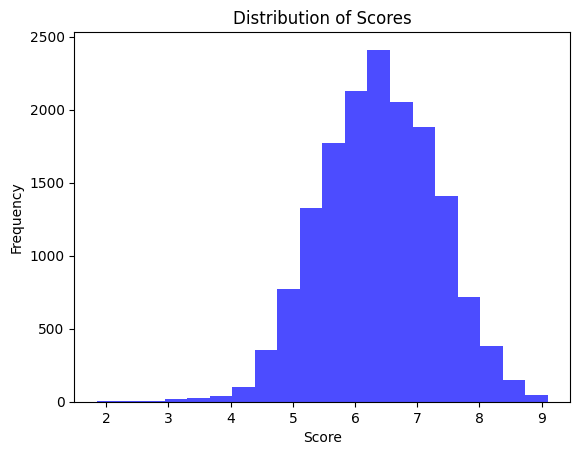

In [24]:
import matplotlib.pyplot as plt

plt.hist(filtered_item_data_df['Score'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [25]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Replace 'UNKNOWN' with NaN for consistent handling of missing values
filtered_item_data_df['Score'] = filtered_item_data_df['Score'].replace('UNKNOWN', pd.NA)

# Initialize SimpleImputer with mean or median strategy
imputer = SimpleImputer(strategy='mean')  # Change to 'median' if distribution is skewed

# Apply imputation on the Score column
filtered_item_data_df['Score'] = imputer.fit_transform(filtered_item_data_df[['Score']])

# Verify that there are no missing values left in Score
print(filtered_item_data_df['Score'].isna().sum())  # Should print 0


0


In [26]:
# Keep rows where both 'Score' and 'Release_Year' are not null
filtered_item_data_df = filtered_item_data_df[filtered_item_data_df["Score"].notna() & filtered_item_data_df["Release_Year"].notna()]

In [27]:
print(filtered_item_data_df.isna().sum())

anime_id                                                                                    0
Name                                                                                        0
English name                                                                                0
Other name                                                                                  0
Score                                                                                       0
                                                                                           ..
Studio_trenova                                                                              0
Studio_ufotable                                                                             0
Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive    0
Studio_ufotable, feel., Studio Flag                                                         0
Release_Year                                                

In [28]:
filtered_item_data_df.shape

(19848, 1568)

In [29]:
user_data.columns

Index(['user_id', 'Username', 'Mean Score', 'Completed', 'avg_Action',
       'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
       'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
       'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
       'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
       'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
       'Age', 'Viewer_Category', 'Category_Classic_Era_Fans',
       'Category_Gen_Alpha_Viewers', 'Category_Millennial_Favorites',
       'Category_Retro_Anime_Lovers', 'Category_Zoomer_Picks', 'Gender_Female',
       'Gender_Male', 'Gender_Non-Binary'],
      dtype='object')

In [30]:
filtered_item_data_df.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Synopsis',
       'Source', 'Rating', 'Rank', 'Popularity',
       ...
       'Studio_pH Studio, D & D Pictures', 'Studio_pH Studio, Noovo',
       'Studio_production doA', 'Studio_studio MOTHER', 'Studio_studio YOG',
       'Studio_trenova', 'Studio_ufotable',
       'Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive',
       'Studio_ufotable, feel., Studio Flag', 'Release_Year'],
      dtype='object', length=1568)

In [31]:
user_input.columns

Index(['Username', 'Gender', 'Mean Score', 'Completed', 'Birth_Year',
       'user_id', 'anime_id', 'Anime Title', 'rating', 'Genres',
       'Genre_Action', 'Genre_Adventure', 'Genre_Avant Garde',
       'Genre_Award Winning', 'Genre_Boys Love', 'Genre_Comedy', 'Genre_Drama',
       'Genre_Ecchi', 'Genre_Erotica', 'Genre_Fantasy', 'Genre_Girls Love',
       'Genre_Gourmet', 'Genre_Hentai', 'Genre_Horror', 'Genre_Mystery',
       'Genre_Romance', 'Genre_Sci-Fi', 'Genre_Slice of Life', 'Genre_Sports',
       'Genre_Supernatural', 'Genre_Suspense'],
      dtype='object')

In [32]:
# Check if any column in filtered_item_data_df contains the value 'UNKNOWN'
columns_with_unknown = filtered_item_data_df.columns[filtered_item_data_df.isin(['UNKNOWN']).any()]

# Print the columns that contain 'UNKNOWN'
print("Columns containing 'UNKNOWN':", list(columns_with_unknown))


Columns containing 'UNKNOWN': ['English name', 'Other name', 'Scored By']


In [33]:
unknown_counts = filtered_item_data_df.isin(['UNKNOWN']).sum().sum()
print(f"Total instances with 'UNKNOWN' values: {unknown_counts}")

Total instances with 'UNKNOWN' values: 15974


In [34]:
from scipy.sparse import csr_matrix, hstack
import numpy as np
import pandas as pd

def prepare_training_data(user_input_df, user_data_df, filtered_item_data_df):
    """
    Prepares training data for a neural network using sparse matrices during processing,
    then converts back to dense arrays in the output.
    
    Parameters:
    -----------
    user_input_df : DataFrame
        Contains user ratings for anime with columns including user_id, anime_id, rating
    user_data_df : DataFrame
        Contains user demographic data and average genre ratings
    filtered_item_data_df : DataFrame
        Contains anime metadata including genres, types, and ratings
        
    Returns:
    --------
    dict
        A dictionary containing:
        - 'X_U': User features array (dense)
        - 'X_A': Anime features array (dense)
        - 'Y': Rating values array
        - 'X_U_columns': List of column names for user features
        - 'X_A_columns': List of column names for anime features
        - 'Y_column': Name of the rating column
        - 'X_U_indices': List of indices for user features
        - 'X_A_indices': List of indices for anime features
        - 'Y_index': Index of the rating column
        - 'merged_df': The merged and cleaned dataframe
    """
    # Step 1: Merge dataframes with suffixes to handle column conflicts
    merged_df = user_input_df.merge(user_data_df, on='user_id', suffixes=('', '_user'))
    merged_df = merged_df.merge(filtered_item_data_df, on='anime_id', suffixes=('', '_anime'))
    
    # Step 2: Identify columns to drop (non-numerical or identifiers)
    columns_to_drop = ['Username', 'user_id', 'anime_id', 'Anime Title', 
                     'Name', 'English name', 'Other name', 'Synopsis', 
                     'Source', "Scored by", 'Image URL']
    
    # Only drop columns that actually exist in the merged dataframe
    columns_to_drop = [col for col in columns_to_drop if col in merged_df.columns]
    
    # Drop identified columns
    cleaned_df = merged_df.drop(columns_to_drop, axis=1)
    
    # Step 3: Define columns for each component
    X_U_columns = [
        'Mean Score', 'Completed',
        'avg_Action', 'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
        'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
        'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
        'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
        'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
        'Gender_Female', 'Gender_Male', 'Gender_Non-Binary',
        'Category_Classic_Era_Fans', 'Category_Gen_Alpha_Viewers',
        'Category_Millennial_Favorites', 
        'Category_Retro_Anime_Lovers', 
        'Category_Zoomer_Picks'
    ]
    
    excluded_columns = ['anime_id', 'Name', 'English name', 'Other name',
                      'Score', "Synopsis", "Source", "Rank","Rating"]
    
    X_A_columns = [col for col in filtered_item_data_df.columns 
                  if col not in excluded_columns and col in cleaned_df.columns]
    X_U_columns = [col for col in X_U_columns if col in cleaned_df.columns]
    
    Y_column = "rating"
    if Y_column not in cleaned_df.columns:
        raise ValueError(f"Rating column '{Y_column}' not found in merged dataframe")
    
    # Step 4: Get indices for features
    X_U_indices = [cleaned_df.columns.get_loc(col) for col in X_U_columns]
    X_A_indices = [cleaned_df.columns.get_loc(col) for col in X_A_columns]
    Y_index = cleaned_df.columns.get_loc(Y_column)
    
    # Step 5: Process with sparse matrices
    # Convert relevant portions to sparse format
    X_U_sparse = csr_matrix(cleaned_df.iloc[:, X_U_indices].values)
    X_A_sparse = csr_matrix(cleaned_df.iloc[:, X_A_indices].values)
    
    # Perform sparse operations if needed (e.g., scaling)
    # ... (your sparse-compatible preprocessing here) ...
    
    # Convert back to dense for output (if your model requires dense inputs)
    X_U = X_U_sparse.toarray()
    X_A = X_A_sparse.toarray()
    Y = cleaned_df.iloc[:, Y_index].values
    
    return {
        "X_U": X_U,
        "X_A": X_A,
        "Y": Y,
        "X_U_columns": X_U_columns,
        "X_A_columns": X_A_columns,
        "Y_column": Y_column,
        "X_U_indices": X_U_indices,
        "X_A_indices": X_A_indices,
        "Y_index": Y_index,
        "merged_df": cleaned_df,
    }


In [35]:
# Prepare the training data
# Select a smaller dataframe with 200000 samples from user_input
user_input_sample = user_input.sample(n=200000, random_state=42)

# Ensure all columns in user_input_sample, user_data, and filtered_item_data_df are numeric
user_input_sample = user_input_sample.select_dtypes(include=[np.number])
user_data = user_data.select_dtypes(include=[np.number])
filtered_item_data_df = filtered_item_data_df.select_dtypes(include=[np.number])

# Prepare the training data using the sampled dataframe
result = prepare_training_data(user_input_sample, user_data, filtered_item_data_df)

# Access the prepared data
X_U = result['X_U']  # User features
X_A = result['X_A']  # Anime features
Y = result['Y']      # Ratings

# You can also access indices if needed
X_U_indices = result['X_U_indices']
X_A_indices = result['X_A_indices']

In [36]:
X_U.shape

(199537, 31)

In [37]:
X_A.shape

(199537, 1557)

In [38]:
Y.shape

(199537,)

In [39]:
Y[:10]

array([ 8,  7,  8,  8,  8, 10,  8,  6, 10,  8], dtype=int64)

# Neural Network for implementing Content Based Filtering:

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np

# --- Scaling the data ---
# Create scalers
user_scaler = StandardScaler()
anime_scaler = StandardScaler()

# Ensure all columns in X_A are numeric
# Convert categorical columns (e.g., 'Rating') to numeric using one-hot encoding
#X_A_df = pd.DataFrame(X_A, columns=result['X_A_columns'])  # Convert X_A to DataFrame for easier processing

# print(X_A_df.columns)  # Check the columns after encoding
# Scale the features
X_U_scaled = user_scaler.fit_transform(X_U)
X_A_scaled = anime_scaler.fit_transform(X_A)

# --- Splitting the scaled data ---
# First split: 80% train+val, 20% test
X_U_temp, X_U_test, X_A_temp, X_A_test, Y_temp, Y_test = train_test_split(
    X_U_scaled, X_A_scaled, Y, test_size=0.2, random_state=42
)

# Second split: 75% train, 25% validation (results in 60% train, 20% val, 20% test overall)
X_U_train, X_U_val, X_A_train, X_A_val, Y_train, Y_val = train_test_split(
    X_U_temp, X_A_temp, Y_temp, test_size=0.25, random_state=42
)

print(f"Training set: {X_U_train.shape[0]} samples")
print(f"Validation set: {X_U_val.shape[0]} samples")
print(f"Test set: {X_U_test.shape[0]} samples")




Training set: 119721 samples
Validation set: 39908 samples
Test set: 39908 samples


In [85]:
# --- TensorFlow model ---
# Set random seed for reproducibility
tf.random.set_seed(42)

# Define inputs for user and item features
user_input = tf.keras.Input(shape=(X_U_train.shape[1],), name="user_input")
item_input = tf.keras.Input(shape=(X_A_train.shape[1],), name="item_input")

# Define user network with dropout for regularization
user_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='linear')
], name="user_nn")

# Define item network with dropout for regularization
item_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='linear')
], name="item_nn")

# Pass inputs through respective networks
vu = user_nn(user_input)
va = item_nn(item_input)

# Compute dot product
output = tf.keras.layers.Dot(axes=1)([vu, va])

# Create model
model = tf.keras.Model([user_input, item_input], output)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# Model summary
model.summary()

# Train the model
history = model.fit(
    [X_U_train, X_A_train],
    Y_train,
    validation_data=([X_U_val, X_A_val], Y_val),
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1557)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_nn             │ (None, 32)        │     53,216 │ user_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_nn             │ (None, 32)        │    443,872 │ item_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ user_nn[0][0],    │
│                     │                   │            │ item_nn[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 497,088 (1.90 MB)

 Trainable params: 495,296 (1.89 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/60
3742/3742 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 26.1757 - mean_absolute_error: 3.3677 - val_loss: 1.9903 - val_mean_absolute_error: 1.0939 - learning_rate: 0.0010
Epoch 2/60
3742/3742 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.1573 - mean_absolute_error: 1.1293 - val_loss: 2.1195 - val_mean_absolute_error: 1.0711 - learning_rate: 0.0010
Epoch 3/60
3742/3742 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.0185 - mean_absolute_error: 1.0906 - val_loss: 1.9718 - val_mean_absolute_error: 1.0637 - learning_rate: 0.0010
Epoch 4/60
3742/3742 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.9329 - mean_absolute_error: 1.0646 - val_loss: 1.8380 - val_mean_absolute_error: 1.0419 - learning_rate: 0.0010
Epoch 5/60
3742/3742 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.8551 - mean_absolute_error: 1.0416 - val_loss: 1.8203 - val_mean_absolute_error: 1.0285 - learning_rate: 0.0010
Epoch 6/60
3742/3742 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.7967 - mean_absolute_error: 1.0244 - val_loss: 1.85

In [88]:
# Evaluate on test set
test_results = model.evaluate([X_U_test, X_A_test], Y_test, verbose=1)
print(f"Test loss (MSE): {test_results[0]}")
print(f"Test MAE: {test_results[1]}")

1248/1248 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - loss: 1.8184 - mean_absolute_error: 1.0202
Test loss (MSE): 1.7980930805206299
Test MAE: 1.020281434059143


In [87]:
# Save in TensorFlow SavedModel format
model.export('../saved_model/recommender_model_5')

# Save in HDF5 format
model.save('../saved_model/recommender_model_5.h5', save_format='h5')


INFO:tensorflow:Assets written to: ../saved_model/recommender_model_5\assets


INFO:tensorflow:Assets written to: ../saved_model/recommender_model_5\assets


Saved artifact at '../saved_model/recommender_model_5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 31), dtype=tf.float32, name='user_input'), TensorSpec(shape=(None, 1557), dtype=tf.float32, name='item_input')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2408001271568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2408001269840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2408001270416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2408001270992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2408001268496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2408001268688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2408001270800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2408001266960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2403635120848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2403639076688: Tenso

In [ ]:
# # Save in TensorFlow SavedModel format
# model.export('../saved_model/recommender_model_2')

# # Save in HDF5 format
# model.save('../recommender_model_2.h5', save_format='h5')


In [42]:
model=tf.keras.models.load_model('../saved_model/recommender_model_5.h5')


In [48]:
import numpy as np
X_U_test[:5]


array([[ 0.31605044,  0.28676744,  0.68924518,  0.66582542,  0.13524514,
         0.27519948,  0.16384154,  0.40176121,  0.28521592, -0.0258361 ,
         0.07554984,  0.82949484, -0.9013403 ,  1.51774367,  0.08323007,
         0.50775094, -0.03526983,  0.33871612,  0.26420488,  0.09730152,
         1.24948189,  0.58068136, -0.28802484, -0.64339153,  0.65163899,
        -0.07301054, -0.09264306, -0.04197823,  0.9254281 , -0.90367672,
        -0.03912644],
       [ 0.66211604, -0.83392603,  0.10276698, -0.29186793,  1.00477753,
         0.0748365 ,  0.16384154,  1.07321697,  0.8735496 ,  0.1912855 ,
         0.07554984, -0.54774334,  0.11111825,  0.08202951,  0.08323007,
         0.27352643, -1.016382  ,  0.78655371,  0.7205421 ,  1.32953033,
         1.77672311, -0.96115538,  0.3522681 , -0.64339153,  0.65163899,
        -0.07301054, -0.09264306, -0.04197823,  0.9254281 , -0.90367672,
        -0.03912644],
       [ 1.10705753, -0.81991736,  0.77302778,  1.18505676,  1.80251368,
       

In [49]:
X_A_test[:5]

array([[-0.83016473,  0.5503191 ,  1.26870393, ...,  0.        ,
        -0.01205643,  1.17337639],
       [-0.87486834,  2.44961978,  3.46816864, ...,  0.        ,
        -0.01205643, -0.78785551],
       [-0.85624184,  2.5307131 ,  2.0000329 , ...,  0.        ,
        -0.01205643, -1.34820749],
       [ 0.13628473, -0.35467788, -0.59155091, ...,  0.        ,
        -0.01205643, -0.36759153],
       [ 1.10486294, -0.38682533, -0.70125305, ...,  0.        ,
        -0.01205643, -0.08741555]])

In [44]:
#Make predictions on X-U_test and X-A_test
predictions = model.predict([X_U_test[:20], X_A_test[:20]])
predictions[:20]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([[8.337347 ],
       [7.479854 ],
       [8.987913 ],
       [7.603134 ],
       [8.300107 ],
       [7.441692 ],
       [5.81194  ],
       [7.8548822],
       [8.422681 ],
       [7.451963 ],
       [8.152467 ],
       [6.53503  ],
       [8.275433 ],
       [8.415625 ],
       [8.422006 ],
       [7.1949625],
       [7.2005258],
       [8.943519 ],
       [7.7927327],
       [7.4857388]], dtype=float32)

In [45]:
Y_test[:20]

array([ 9,  7, 10,  7,  7,  9,  1,  8,  9,  9,  6,  8,  9,  8, 10,  8,  7,
       10,  7,  8], dtype=int64)

In [ ]:
# Optional: Plot training history
# Uncomment if you're running in an environment that supports plotting
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()
"""

Utilizing MLP from scikit learn 